# **Project 2: Clustering**

*Lumi Huang, Christian Warloe, Ke Zhao, Landi Luo*

## Introduction 

---


Clustering algorithms are unsupervised methods for finding groups of data points that have similar representations in a feature space. Unlike classification, in clustering there does not exist an *a priori* grouping/labeling of the data points.  

The goals of this project include: 


1.   Finding proper representations of the data such that the clustering is efficient and gives out reasonable results
2.   Performing K-means clustering on the dataset and evaluating its performance  
3.   Trying various preprocessing methods which may increase the performance of the clustering



## Dataset

---


The dataset used in this project is the "20 Newsgroups" dataset, the same one that we used in **Project 1**. The dataset consists of a collection of approximately 20,000 newsgroup documents partitioned (nearly) evenly across 20 topics. In order to define the clustering task, we ignore the document labels (i.e. which topic each document is classified into) and then aim to cluster more similar documents with each other. We will then use the document labels as the ground truth to evaluate the performance of the clustering task.  

We started with a simple clustering task, where we tried to cluster two well-separated classes in the dataset: "Computer Technology" (Class 1) and "Recreational Activity" (Class 2). We took all the topics from these two classes and performed unsupervised clustering to try to cluster the documents into 2 clusters. We determined how pure each cluster is by comparing the clusters with the true labels. 

<center><b>Table 1</b>:  Two well-separated classes</center>

| Class 1     | Class 2 |
|--------------------------|-----------------------|
| `comp.graphics`            | `rec.autos`             |
| `comp.os.ms-windows.misc`  | `rec.motorcycles`       |
| `comp.sys.ibm.pc.hardware` | `rec.sport.baseball`    |
| `comp.sys.mac.hardware`    | `rec.sport.hockey`      |

In [0]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np 
np.random.seed(42)
import random 
random.seed(42)

categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics',
              'comp.sys.mac.hardware', 'comp.os.ms-windows.misc',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

binary_labels = np.array(dataset.target >= 4, dtype = int)
# recreational activity = 1, computer technology = 0

## 1. Building the TF-IDF matrix

---



We first converted our collecion of news documents into a document-term matrix. We then transformed the document-term matrix into a TF-IDF matrix. We excluded english stopwords and used `min_df=3`. We did not perform stemming or lemmatization as we did in Project 1.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer

stop_words = text.ENGLISH_STOP_WORDS
vectorizer = CountVectorizer(min_df=3, stop_words='english')

count_vec_matrix = vectorizer.fit_transform(dataset.data)

tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(count_vec_matrix)

**QUESTION 1: Report the dimensions of the TF-IDF matrix you get.**  

The shape of the TF-IDF matrix is reported as ($d, t$) where $d$ is the number of documents and $t$ is the number of terms.

In [0]:
print('The shape of the TF-IDF matrix is', tfidf_matrix.shape)

The shape of the TF-IDF matrix is (7882, 27768)


## 2. K-means clustering

---



K-means clustering is one of the simplest and popular unsupervised machine learning algorithms. Given a set of data points, the algorithm tries to find $k$ clusters such that each data point belongs to only one cluster, and the sum of the squares of the distances between each data point and the center of the cluster it belongs to is minimized. Using `sklearn.cluster.KMeans`, we applied k-means clustering using $k=2$ on the TF-IDF transformed data. We set `random_state=0`, `n_init=30`, and `max_iter=1000`, where `n_init` is the number of time the k-means algorithm will be run with different centroid seeds, and `max_iter` is the maximum number of iterations of the k-means algorithm for a single run.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(tfidf_matrix)

In [0]:
#Labels of each point
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

### (a) Contingency Table

**QUESTION 2: Report the contingency table of your clustering result.**  

The contingency table (Table 2) is shown below, where the clusters that were determined via k-means are cross tabulated with their true class labels. In Table 2, the row value 0 denotes **Class 1** and 1 denotes **Class 2** (corresponding to Table 1). Likewise, the column value 0 denotes **Cluster 1** and 1 denotes **Cluster 2**. From this table, it appears that our initial k-means clustering algorithm did not perform very well, as only 4 documents were correctly classified into Class 1 and 2261 into Class 2, whereas 3899 documents of Class 1 were incorrectly classified into Cluster 2, and 1718 documents of Class 2 were incorrectly classified into Cluster 1. 

In [0]:
#contigency matrix
import pandas as pd
print('Table 2: Contingency Table')
pd.crosstab(binary_labels, kmeans.labels_, rownames=['class'], colnames=['cluster'])

Table 2: Contingency Table


cluster     0     1
class              
0           4  3899
1        1718  2261

### (b) Clustering Performance Evaluation

There are various metrics that are used to evaluate the performance of a clustering algorithm. The `sklearn.metrics.cluster` submodule contains evaluation metrics for cluster analysis results. We used the following measures to assess the performance of our k-means clustering by comparing it our results with the ground truth (true class labels):    
- **homogeneity score**: a measure of how “pure” the clusters are. If each cluster contains
only data points from a single class, then homogeneity is satisfied.
- **completeness score**: whether all members of a given class are assigned to the same cluster.
- **V-measure**: the harmonic mean of homogeneity score and completeness score.
- **adjusted Rand score**: is similar to accuracy measure, which computes
similarity between the clustering labels and ground truth labels.
- **adjusted mutual info score**: measures the mutual information (agreement)
between the cluster label distribution and the ground truth label distributions.

**QUESTION 3: Report the 5 measures above for the K-means clustering results you get.**  

All five measures give pretty low scores, indicating that the clustering algorithm did not perform very well. These results are in line with the contingency table results, in which we saw that more documents were placed into the wrong cluster than the correct one. The poor performance is not surprising, given that it was an initial clustering on the data before performing feature extraction or dimensionality reduction.


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#homogeneity score
from sklearn.metrics.cluster import homogeneity_score
print('- homogeneity score: %0.3f' % homogeneity_score(binary_labels, kmeans.labels_))

#completeness score
from sklearn.metrics.cluster import completeness_score
print('- completeness score: %0.3f' % completeness_score(binary_labels, kmeans.labels_))

#v-measure
from sklearn.metrics.cluster import v_measure_score
print('- v-measure: %0.3f' % v_measure_score(binary_labels, kmeans.labels_))

#adjusted rand score
from sklearn.metrics.cluster import adjusted_rand_score
print('- adjusted rand score: %0.3f' % adjusted_rand_score(binary_labels, kmeans.labels_))

#adjusted mutual info score
from sklearn.metrics.cluster import adjusted_mutual_info_score
print('- adjusted mutual info score: %0.3f' % adjusted_mutual_info_score(binary_labels, kmeans.labels_))


- homogeneity score: 0.254
- completeness score: 0.335
- v-measure: 0.289
- adjusted rand score: 0.181
- adjusted mutual info score: 0.254


## 3. Dimensionality reduction

---




We saw that the k-means clustering algorithm did not perform well on the high-dimensional sparse TF-IDF matrix. In this part we try to find a “better” representation tailored to the way that K-means clustering algorithm works, by reducing the dimension of our data before clustering. We used Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) for dimensionality reduction.

### (a) Top *r* Singular Values  

We first want to find the effective dimension of the data by looking at the top *r* principal components, and seeing how many of them are significant in reconstructing the matrix with the truncated SVD representation. We plotted the percent of variance retained vs number of principal components from r=1 to r=1000.

In [0]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=1000)
svd.fit_transform(tfidf_matrix)

array([[ 0.12491455,  0.01779357, -0.01403145, ...,  0.01883042,
         0.00453007,  0.01426934],
       [ 0.11487509,  0.05393205, -0.03519844, ..., -0.02791959,
         0.05226082, -0.02722541],
       [ 0.14972207,  0.13673575,  0.09422607, ..., -0.0149004 ,
         0.02411903,  0.01014313],
       ...,
       [ 0.09497781,  0.01605395, -0.0273249 , ..., -0.03040297,
        -0.01538784, -0.01907799],
       [ 0.14869694,  0.01003593, -0.01292828, ..., -0.0265401 ,
         0.02102857, -0.02226303],
       [ 0.09084749, -0.00094235, -0.00702921, ..., -0.02321854,
         0.03059329, -0.01119597]])

**QUESTION 4: Report the plot of the percent of variance the top r principle components can retain v.s. r, for r = 1 to 1000.**  

We observed that the percent of variance explained increases as we increase the number of principal components r. 

(0, 1001)

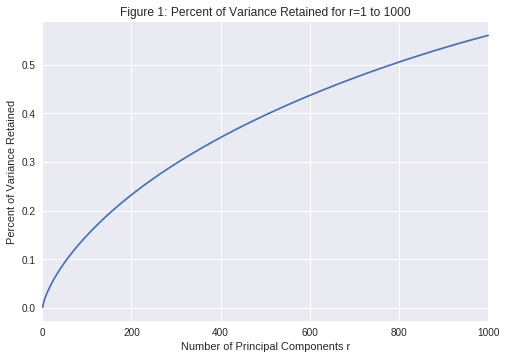

In [0]:
var_retained = []

for n in range(1, 1001):
  var_retained.append(svd.explained_variance_ratio_[0:n].sum())


r=[r for r in range(1, 1001)]
plt.figure()
plt.plot(r, var_retained)
plt.xlabel('Number of Principal Components r')
plt.ylabel('Percent of Variance Retained')
plt.title('Figure 1: Percent of Variance Retained for r=1 to 1000')
plt.xlim([0, 1001])

### (b) SVD and NMF

**QUESTION 5:
Let r be the dimension that we want to reduce the data to (i.e. `n_components`).  
Try r = 1,2,3,5,10,20,50,100,300, and plot the 5 measure scores vs. r for both SVD and NMF. Report the best r choice for SVD and NMF respectively.**  
*Note: what is “best” after all? What if some measures contradict with each other? Here you are faced with this challenge that you need to decide which measure you value the most, and design your own standard of “best”. Please explain your standard and justify it.*

**SVD**  

We plotted the 5 measure scores vs. r for SVD, using r = 1, 2, 3, 5, 10, 20, 50, 100, and 300. It appears that all 5 scores follow a similar trend. We chose the "best" r value as the highest value of r, since it indicates the number of principal components that return the highest scores for the 5 performance evaluators. From *Figure 2*, we observed a peak in all of the scores between r=1 and r=15. We zoomed in to pinpoint this peak (*Figure 3*) and found that all 5 scores have the highest value at **r=2** (with score values ranging from 0.6 - 0.7). From there, the scores all dropped and reached relative stability from r=5. 



In [0]:
#svd
r=np.array([1,2,3,5,10,20,50,100,300])
h_score = []
c_score = []
v_score = []
r_score = []
mi_score = []

for n in r:
  svd = TruncatedSVD(n_components=n)
  svd_matrix = svd.fit_transform(tfidf_matrix)
  kmeans_svd = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(svd_matrix)
  h_score.append(homogeneity_score(binary_labels, kmeans_svd.labels_))
  c_score.append(completeness_score(binary_labels, kmeans_svd.labels_))
  v_score.append(v_measure_score(binary_labels, kmeans_svd.labels_))
  r_score.append(adjusted_rand_score(binary_labels, kmeans_svd.labels_))
  mi_score.append(adjusted_mutual_info_score(binary_labels, kmeans_svd.labels_))
  

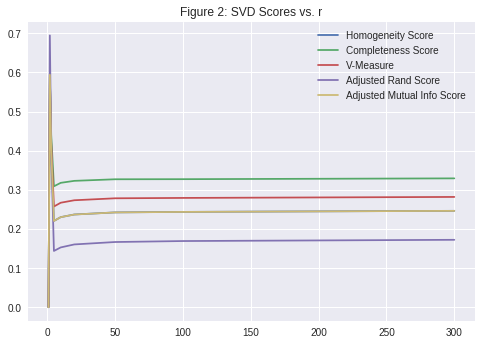

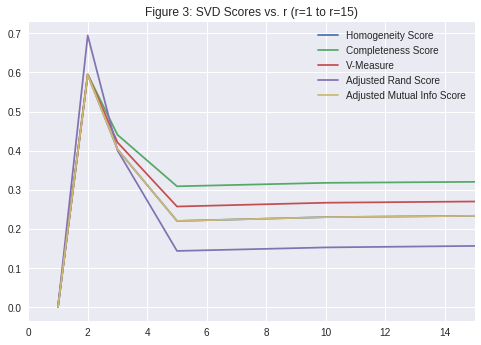


- Homogenity Scores:  [0.0003003030178761853, 0.59411421655068, 0.4038274444079575, 0.22064879115044808, 0.23037527478381098, 0.2371168323734726, 0.242488600144672, 0.24378608232945773, 0.24649624210214638]

- Completeness Scores:  [0.0003047688479979988, 0.5953891944269935, 0.44079110302818475, 0.309171298975254, 0.31801958696890004, 0.32309487903924067, 0.32714066941714903, 0.32739639470153314, 0.329445272862752]

- V-Measure:  [0.0003025194525487269, 0.5947510221916851, 0.42150043991804376, 0.25751486079404234, 0.26719378624532575, 0.2735081495553912, 0.2785246026362978, 0.2794717542735299, 0.2819974585229678]

- Adjusted Rand Scores:  [0.00033904080274629444, 0.6947582134941215, 0.40104814855420523, 0.14399759653523284, 0.15299598167319026, 0.1606349547110235, 0.1667970920946106, 0.1692943864792963, 0.17244210591100684]

- Adjusted Mutual Info Scores:  [0.00020877974994934834, 0.594077057565299, 0.4037728628598323, 0.22057743068716046, 0.2303048054837334, 0.23704698083425718, 0.24

In [0]:
plt.plot(r, h_score)
plt.plot(r, c_score)
plt.plot(r, v_score)
plt.plot(r, r_score)
plt.plot(r, mi_score)
plt.legend(['Homogeneity Score', 'Completeness Score', 'V-Measure', 
            'Adjusted Rand Score', 'Adjusted Mutual Info Score'], loc='upper right')
plt.title('Figure 2: SVD Scores vs. r')
plt.show()

#looks like the best r lies between 1 to 15. Let's zoom in
plt.plot(r, h_score)
plt.plot(r, c_score)
plt.plot(r, v_score)
plt.plot(r, r_score)
plt.plot(r, mi_score)
plt.legend(['Homogeneity Score', 'Completeness Score', 'V-Measure', 
            'Adjusted Rand Score', 'Adjusted Mutual Info Score'], loc='upper right')
plt.xlim([0,15])
plt.title('Figure 3: SVD Scores vs. r (r=1 to r=15)')
plt.show()

print('\n- Homogenity Scores: ', h_score)
print('\n- Completeness Scores: ', c_score)
print('\n- V-Measure: ', v_score)
print('\n- Adjusted Rand Scores: ', r_score)
print('\n- Adjusted Mutual Info Scores: ', mi_score)

**NMF**  

Similar to SVD, we plotted the 5 measure scores vs. r for NMF, using r = 1, 2, 3, 5, 10, 20, 50, 100, and 300. We noticed a similar trend among all the measure scores across the different *r*'s. We decided to use the r value with the highest scores for the 5 performance metrics as the "best" r, since it indicates the number of principal components that return the highest scores for the 5 performance metrics. Similar to SVD, all 5 scores have the highest value at **r=2**, so we chose that as our "best" r (see *Figure 5*). 





In [0]:
#NMF
from sklearn.decomposition import NMF

r=np.array([1,2,3,5,10,20,50,100,300])
h_score = []
c_score = []
v_score = []
r_score = []
mi_score = []

for n in r:
  nmf = NMF(n_components=n)
  nmf_matrix = nmf.fit_transform(tfidf_matrix)
  kmeans_nmf = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(nmf_matrix)
  h_score.append(homogeneity_score(binary_labels, kmeans_nmf.labels_))
  c_score.append(completeness_score(binary_labels, kmeans_nmf.labels_))
  v_score.append(v_measure_score(binary_labels, kmeans_nmf.labels_))
  r_score.append(adjusted_rand_score(binary_labels, kmeans_nmf.labels_))
  mi_score.append(adjusted_mutual_info_score(binary_labels, kmeans_nmf.labels_))

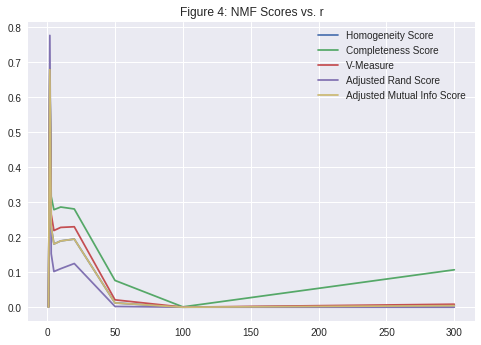

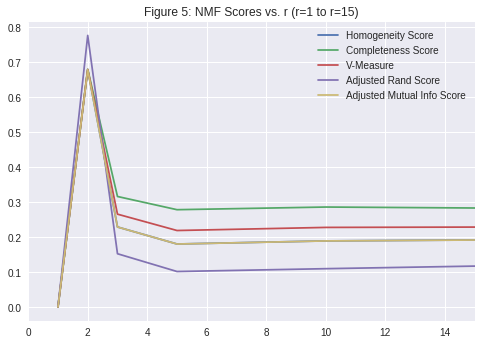


- Homogenity Scores:  [0.0003003030178761853, 0.6790483562300399, 0.22934270331135687, 0.1806306858119277, 0.18949063824914214, 0.1946850307795827, 0.012164455836217796, 3.229909238117286e-05, 0.004393330817746327]

- Completeness Scores:  [0.0003047688479979988, 0.680131609210451, 0.3164839569386385, 0.2787087965375742, 0.2863202773400154, 0.2807966828126232, 0.07643205048933492, 0.0008708112923969601, 0.10690003602994713]

- V-Measure:  [0.0003025194525487269, 0.6795895510492934, 0.2659572773735104, 0.2191989280037279, 0.22805282652942666, 0.22994327341498996, 0.02098850939409846, 6.228787721582397e-05, 0.008439806180925019]

- Adjusted Rand Scores:  [0.00033904080274629444, 0.7770177788377391, 0.15279745011356483, 0.10195567187855815, 0.11005468386525068, 0.12483716386160316, 0.0020134742365048113, 1.4729438725199227e-05, -9.300120846818783e-05]

- Adjusted Mutual Info Scores:  [0.00020877974994934834, 0.6790189730005426, 0.2292721394788808, 0.180555656934245, 0.18941642161552888, 

In [0]:
plt.plot(r, h_score)
plt.plot(r, c_score)
plt.plot(r, v_score)
plt.plot(r, r_score)
plt.plot(r, mi_score)
plt.legend(['Homogeneity Score', 'Completeness Score', 'V-Measure', 
            'Adjusted Rand Score', 'Adjusted Mutual Info Score'], loc='upper right')
plt.title('Figure 4: NMF Scores vs. r')
plt.show()

#looks like the best r lies between 1 to 15. Let's zoom in
plt.plot(r, h_score)
plt.plot(r, c_score)
plt.plot(r, v_score)
plt.plot(r, r_score)
plt.plot(r, mi_score)
plt.legend(['Homogeneity Score', 'Completeness Score', 'V-Measure', 
            'Adjusted Rand Score', 'Adjusted Mutual Info Score'], loc='upper right')
plt.title('Figure 5: NMF Scores vs. r (r=1 to r=15)')
plt.xlim([0,15])
plt.show()

print('\n- Homogenity Scores: ', h_score)
print('\n- Completeness Scores: ', c_score)
print('\n- V-Measure: ', v_score)
print('\n- Adjusted Rand Scores: ', r_score)
print('\n- Adjusted Mutual Info Scores: ', mi_score)

We conclude that the "best" r for both SVD and NMF is **r=2**.  

<center><b>Table 3</b>:  Performance Metric Results Using r=2</center>  

|           Performance Metric                | SVD | NMF |
|-------------------------------------|-----|-----|
| **Homogeneity Score**           |   0.594  |  0.679   |
| **Completeness Score**         |  0.595   |   0.680  |
| **V-Measure**                          |  0.595   |  0.680   |
| **Adjusted Rand Index**         |   0.695  |  0.777   |
| **Adjusted Mutual Info Score** |  0.594   |   0.679  |




**QUESTION 6: How do you explain the non-monotonic behavior of the measures as r increases?**  

As r increases, we see that the 5 measures have a peak performance at r=2, and then their performance values drop for both SVD and NMF. One possible explanation is that the clustering algorithms do not perform well in high-dimensions (the "curse of dimensionality"). For example, metrics that use the Euclidean distance which works well in two to three-dimensions, do not perform as expected when extrapolated to higher-dimensions. In high dimensions, a curious phenomenon arises: the ratio between the nearest and farthest points approaches 1, i.e. the points essentially become uniformly distant from each other. This phenomenon can be observed for wide variety of distance metrics, but it is more pronounced for the Euclidean metric. The premise of nearest neighbor search is that "closer" points are more relevant than "farther" points, but if all points are essentially uniformly distant from each other, the distinction is meaningless.

*Reference: https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions*

## 4. Visualization

---



**QUESTION 7: Visualize the clustering results for:   
• SVD with its best r  
• NMF with its best r**  

Based on the plots of 5 measure scores v.s. r for both SVD and NMF, the best r for both SVD and NMF is 2 since the 5 measure scores reach the highest when r = 2. The clustering results for SVD and NMF are visualized below by projecting the dim-reduced data points onto 2-D plane.The 5 measure scores for NMF are higher than those for SVD, which indicates that the clustering performs slightly better when NMF is used for dimensionality reduction than when SVD is used in this case. 

In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

svd2 = TruncatedSVD(n_components=2)
svd_matrix2 = svd2.fit_transform(tfidf_matrix)
kmeans_svd2 = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(svd_matrix2)

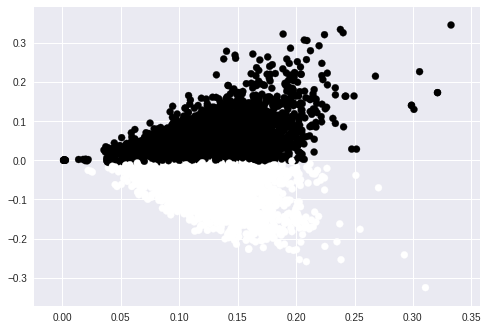

In [0]:
import matplotlib.pyplot as plt
#clustering labels: kmeans_svd2.labels_
#groupd truth class label: binary_labels
plt.scatter(svd_matrix2[:,0], svd_matrix2[:,1], c=kmeans_svd2.labels_)
plt.show()

In [0]:
#homogeneity score
from sklearn.metrics.cluster import homogeneity_score
print('homogeneity score: %0.3f' % homogeneity_score(binary_labels, kmeans_svd2.labels_))

#completeness score
from sklearn.metrics.cluster import completeness_score
print('completeness score: %0.3f' % completeness_score(binary_labels, kmeans_svd2.labels_))

#v-measure
from sklearn.metrics.cluster import v_measure_score
print('v-measure: %0.3f' % v_measure_score(binary_labels, kmeans_svd2.labels_))

#adjusted rand score
from sklearn.metrics.cluster import adjusted_rand_score
print('adjusted rand score: %0.3f' % adjusted_rand_score(binary_labels, kmeans_svd2.labels_))

#adjusted mutual info score
from sklearn.metrics.cluster import adjusted_mutual_info_score
print('adjusted mutual info score: %0.3f' % adjusted_mutual_info_score(binary_labels, kmeans_svd2.labels_))

homogeneity score: 0.596
completeness score: 0.597
v-measure: 0.596
adjusted rand score: 0.696
adjusted mutual info score: 0.596


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
#nmf
from sklearn.decomposition import NMF

nmf2 = NMF(n_components=2)
nmf_matrix2 = nmf2.fit_transform(tfidf_matrix)
kmeans_nmf2 = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(nmf_matrix2)

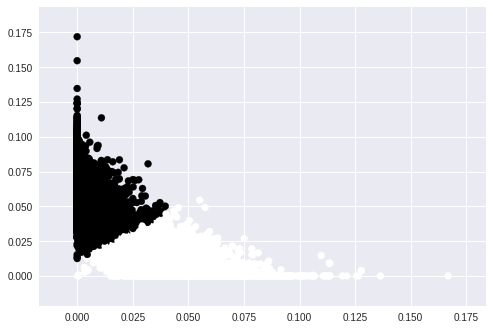

In [0]:
plt.scatter(nmf_matrix2[:,0], nmf_matrix2[:,1], c=kmeans_nmf2.labels_)
plt.show()

In [0]:
#homogeneity score
from sklearn.metrics.cluster import homogeneity_score
print('homogeneity score: %0.3f' % homogeneity_score(binary_labels, kmeans_nmf2.labels_))

#completeness score
from sklearn.metrics.cluster import completeness_score
print('completeness score: %0.3f' % completeness_score(binary_labels, kmeans_nmf2.labels_))

#v-measure
from sklearn.metrics.cluster import v_measure_score
print('v-measure: %0.3f' % v_measure_score(binary_labels, kmeans_nmf2.labels_))

#adjusted rand score
from sklearn.metrics.cluster import adjusted_rand_score
print('adjusted rand score: %0.3f' % adjusted_rand_score(binary_labels, kmeans_nmf2.labels_))

#adjusted mutual info score
from sklearn.metrics.cluster import adjusted_mutual_info_score
print('adjusted mutual info score: %0.3f' % adjusted_mutual_info_score(binary_labels, kmeans_nmf2.labels_))

homogeneity score: 0.679
completeness score: 0.680
v-measure: 0.680
adjusted rand score: 0.777
adjusted mutual info score: 0.679


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


**QUESTION 8: Visualize the transformed data as in part (a)**

The transformation methods below were performed below on SVD-reduced data and NMF-reduced data respectively to see whether they increased the clustering performance. The best r we used was r = 2. 


*   Scaling features s.t. each feature has unit variance, i.e. each column of the reduced-dimensional data matrix has unit variance (if we use the convention that rows correspond to documents).
*   Applying a non-linear transformation to the data vectors. Here we use logarithm transformation below as an example (try c = 0.01):



\begin{align*}
f(x) = sign(x) * (log(|x| + c) - logc), (sign(x))_{i} = \begin{cases}
1 & x_{i} > 0 \\
0 & x_{i} = 0 \\
-1 & x_{i} < 0 \\
\end{cases}
\end{align*}

* Try combining both transformations (in both orders)



In [0]:
def log_fun(matrix):
  c = 0.01
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      x = matrix[i][j]
      if(x > 0):
        sign_x = 1
      elif(x == 0):
        sign_x = 0
      else:
        sign_x = -1
      matrix[i][j] = sign_x * (np.log(abs(x) + c) - np.log(c))
  return matrix

In [0]:
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler,FunctionTransformer


def transform_plot(scal, log, dim_matrix, order):
  if(order == 'Scaler'):
    if(scal == 'TRUE'):
      scaler = StandardScaler()
      matrix_t = scaler.fit_transform(dim_matrix)
    elif(scal == 'FALSE'):
      matrix_t = dim_matrix
    if(log == 'TRUE'):
      fun = FunctionTransformer(log_fun)
      matrix_t = fun.transform(matrix_t)
    elif(log == 'FALSE'):
      matrix_t = matrix_t
  elif(order == 'Log'):
    if(log == 'TRUE'):
      fun = FunctionTransformer(log_fun)
      matrix_t = fun.transform(dim_matrix)
    elif(log == 'FALSE'):
      matrix_t = dim_matrix
    if(scal == 'TRUE'):
      scaler = StandardScaler()
      matrix_t = scaler.fit_transform(matrix_t)
    elif(scal == 'FALSE'):
      matrix_t = matrix_t
    
  kmeans_t = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(matrix_t)
  
  plt.scatter(matrix_t[:,0], matrix_t[:,1], c=kmeans_t.labels_)
  plt.show()
  
  #homogeneity score
  print('homogeneity score: %0.3f' % homogeneity_score(binary_labels, kmeans_t.labels_))
  
  #completeness score
  print('completeness score: %0.3f' % completeness_score(binary_labels, kmeans_t.labels_))
  
  #v-measure
  print('v-measure: %0.3f' % v_measure_score(binary_labels, kmeans_t.labels_))
  
  #adjusted rand score
  print('adjusted rand score: %0.3f' % adjusted_rand_score(binary_labels, kmeans_t.labels_))
  
  #adjusted mutual info score
  print('adjusted mutual info score: %0.3f' % adjusted_mutual_info_score(binary_labels, kmeans_t.labels_))


**Perform transformation on SVD-reduced data**

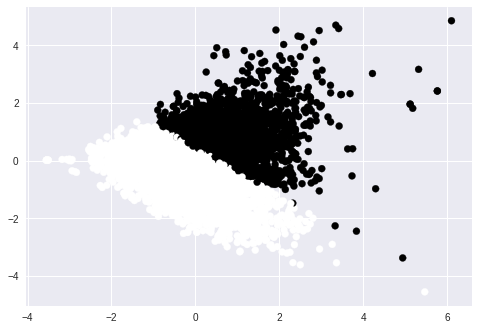

homogeneity score: 0.227
completeness score: 0.256
v-measure: 0.240
adjusted rand score: 0.243
adjusted mutual info score: 0.227


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
#method 1: scaler features
svd_matrix2 = svd2.fit_transform(tfidf_matrix)
transform_plot('TRUE', 'FALSE', svd_matrix2, 'Scaler')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


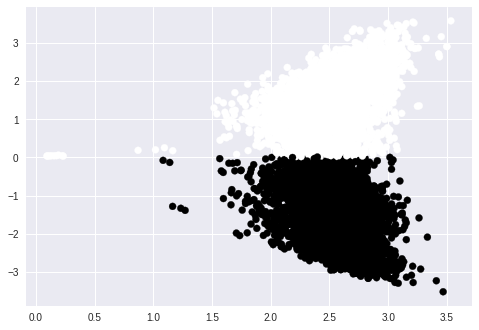

homogeneity score: 0.609
completeness score: 0.609
v-measure: 0.609
adjusted rand score: 0.717
adjusted mutual info score: 0.609


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
#method 2: log transform
# svd_matrix2 = svd2.fit_transform(tfidf_matrix)
transform_plot('FALSE', 'TRUE', svd_matrix2, 'Log')

In [0]:
# #method 1: Scaler Features
# svd_matrix2 = svd2.fit_transform(tfidf_matrix)

# scaler = StandardScaler()
# svd_t1 = scaler.fit_transform(svd_matrix2)
# km_svd_t1 = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(svd_t1)

# plt.scatter(svd_t1[:,0], svd_t1[:,1], c=km_svd_t1.labels_)
# plt.show()

In [0]:
# #method 2: Log transform

# from sklearn.preprocessing import FunctionTransformer

# svd_matrix2 = svd2.fit_transform(tfidf_matrix)
# fun = FunctionTransformer(log_fun)
# svd_t2 = fun.transform(svd_matrix2)

# km_svd_t2 = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(svd_t2)

# plt.scatter(svd_t2[:,0], svd_t2[:,1], c=km_svd_t2.labels_)
# plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


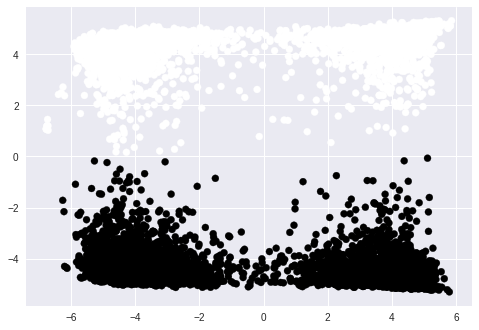

homogeneity score: 0.611
completeness score: 0.611
v-measure: 0.611
adjusted rand score: 0.718
adjusted mutual info score: 0.611


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
#method 3: Scaler -> Log
# svd_matrix2 = svd2.fit_transform(tfidf_matrix)
transform_plot('TRUE', 'TRUE', svd_matrix2, 'Scaler')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


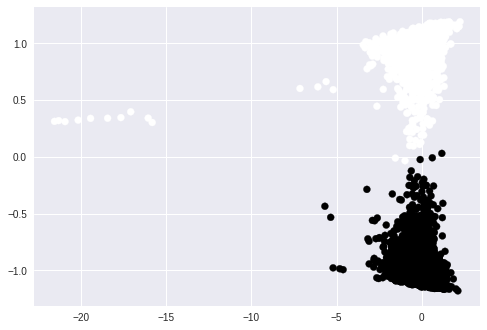

homogeneity score: 0.611
completeness score: 0.611
v-measure: 0.611
adjusted rand score: 0.718
adjusted mutual info score: 0.611


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
#method 4: Log -> Scaler
# svd_matrix2 = svd2.fit_transform(tfidf_matrix)
transform_plot('TRUE', 'TRUE', svd_matrix2, 'Log')

**Perform Transformation on NMF-reduced data**


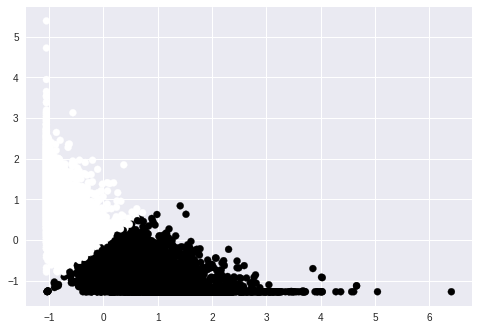

homogeneity score: 0.683
completeness score: 0.686
v-measure: 0.684
adjusted rand score: 0.773
adjusted mutual info score: 0.683


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
#method 1: scaler
nmf_matrix2 = nmf2.fit_transform(tfidf_matrix)
transform_plot('TRUE', 'False', nmf_matrix2, 'Scaler')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


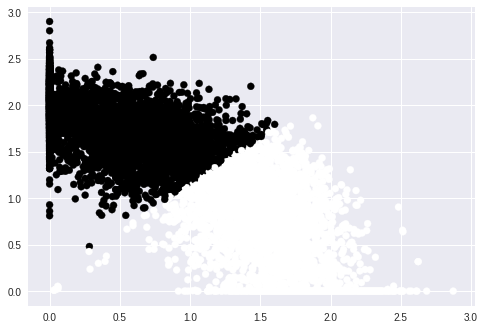

homogeneity score: 0.676
completeness score: 0.679
v-measure: 0.677
adjusted rand score: 0.765
adjusted mutual info score: 0.676


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
#method 2: log
# nmf_matrix2 = nmf2.fit_transform(tfidf_matrix)
transform_plot('FALSE', 'TRUE', nmf_matrix2, 'Log')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


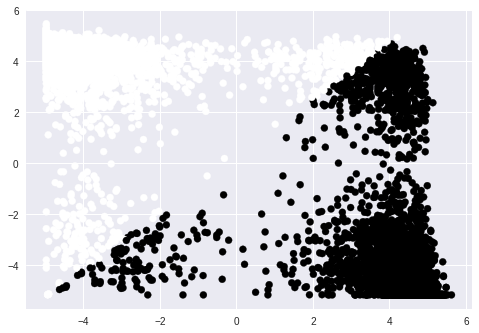

homogeneity score: 0.716
completeness score: 0.716
v-measure: 0.716
adjusted rand score: 0.812
adjusted mutual info score: 0.716


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
#method 3: scaler -> log
# nmf_matrix2 = nmf2.fit_transform(tfidf_matrix)
transform_plot('TRUE', 'TRUE', nmf_matrix2, 'Scaler')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


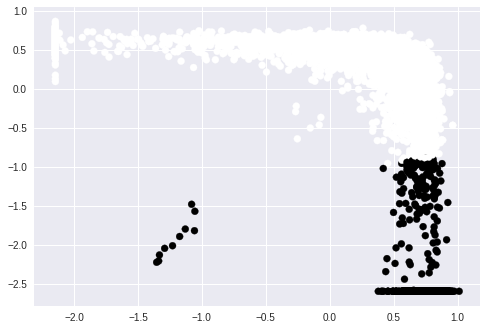

homogeneity score: 0.149
completeness score: 0.264
v-measure: 0.191
adjusted rand score: 0.075
adjusted mutual info score: 0.149


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
#log -> scaler
# nmf_matrix2 = nmf2.fit_transform(tfidf_matrix)
transform_plot('TRUE', 'TRUE', nmf_matrix2, 'Log')

**QUESTION 9: Can you justify why the “logarithm transformation” may improve the clustering results?**

Since k-means clustering algorithm favours clusters are isotropically shaped and clusters with equal variance, data that are heavily skewed may lead to very elongated clusters that are not well captured by this method. Logarithm transformation will reduce the skewness and typically makes the distribution closer to normal, which may improve the clustering results. 

**QUESTION 10: Report the new clustering measures (except for the contingency matrix) for the clustering results of the transformed data.**

The table below showed the 5 measure scores for different data transformation methods. The scores for SVD-reduced  and NMF-reduced data without any transformation were also included. For the SVD-reduced data, the scaling features transformation had the worst clustering result since the 5 measure scores of the SVD-reduced data after scaling features transformation were lower than those of the SVD-reduced data without scaling features transformation. The other transformations including the logarithm transformation, the combination of scaling features and logarithm transformation, and the combination of logarithm transformation all slightly improved the clustering results. The transformations of both combinations had the best clustering results among all transformation methods for the SVD-reduced data. 

For the NMF-reduced data, the transformation of the combination of logarithm transformation and scaling features had the worst clustering results and the scaling features transformation also had lower measure scores than the NMF-reduced data without any transformation. The transformation of the combination of scaling features and logarithm transformation had the best clustering results. 

In general, for transformations that had better results than the data without transformation, the transformations on the NMF-reduced data had better results than the transformations on the SVD-reduced data. 

| Data | homogeneity | completeness | v-measure | adjusted rand | adjusted mutual info |
| --- | --- | --- | --- | --- | --- |
| SVD | 0.596 | 0.597 | 0.596 | 0.696 | 0.596 | 
| SVD + scaling | 0.227 | 0.256 | 0.240 | 0.243 | 0.227 | 
| SVD + log | 0.609 | 0.609 | 0.609 | 0.717 | 0.609 | 
| SVD + scaling + log | 0.611 | 0.611 | 0.611 | 0.718 | 0.611 |
| SVD + log + scaling | 0.611 | 0.611 | 0.611 | 0.718 | 0.611 |
| NMF | 0.679 | 0.680 | 0.680 | 0.777 | 0.679 | 
| NMF + scaling | 0.683 | 0.686 | 0.684 | 0.773 | 0.683 |
| NMF + log | 0.676 | 0.679 | 0.677 | 0.765 | 0.676 | 
| NMF + scaling + log | 0.716 | 0.716 | 0.716 | 0.812 | 0.716 | 
| NMF + log + scaling | 0.149 | 0.264 | 0.191 | 0.075 | 0.149 | 

## 5. Expand Dataset into 20 categories

---



**QUESTION 11: Repeat the following for 20 categories using the same parameters as in 2-class case:  
• Transform corpus to TF-IDF matrix;  
• Directly perform K-means and report the 5 measures and the contingency matrix**


The 5 measure scores and contingency matrix were shown as follows. The clustering results seemed to be bad. This was probably because in a high-dimensional space, the Euclidean distance is not a good metric anymore, in the sense that the distances between data points tends to be almost the same. Dimensionality reduction techniques and transformation methods may be necessary in order to achieve a better result. 

In [0]:
all_dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
all_vectorizer = CountVectorizer(min_df=3, stop_words='english')

all_count_vec_matrix = all_vectorizer.fit_transform(all_dataset.data)

all_tfidf_transformer = TfidfTransformer()
all_tfidf_matrix = all_tfidf_transformer.fit_transform(all_count_vec_matrix)

In [0]:
def transform_plot_20(scal, log, dim_matrix, order, labels):
  if(order == 'Scaler'):
    if(scal == 'TRUE'):
      scaler = StandardScaler()
      matrix_t = scaler.fit_transform(dim_matrix)
    elif(scal == 'FALSE'):
      matrix_t = dim_matrix
    if(log == 'TRUE'):
      fun = FunctionTransformer(log_fun)
      matrix_t = fun.transform(matrix_t)
    elif(log == 'FALSE'):
      matrix_t = matrix_t
  elif(order == 'Log'):
    if(log == 'TRUE'):
      fun = FunctionTransformer(log_fun)
      matrix_t = fun.transform(dim_matrix)
    elif(log == 'FALSE'):
      matrix_t = dim_matrix
    if(scal == 'TRUE'):
      scaler = StandardScaler()
      matrix_t = scaler.fit_transform(matrix_t)
    elif(scal == 'FALSE'):
      matrix_t = matrix_t
    
  kmeans_t = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30).fit(matrix_t)
  
  plt.scatter(matrix_t[:,0], matrix_t[:,1], c=kmeans_t.labels_)
  plt.show()
  
  #homogeneity score
  print('homogeneity score: %0.3f' % homogeneity_score(labels, kmeans_t.labels_))
  
  #completeness score
  print('completeness score: %0.3f' % completeness_score(labels, kmeans_t.labels_))
  
  #v-measure
  print('v-measure: %0.3f' % v_measure_score(labels, kmeans_t.labels_))
  
  #adjusted rand score
  print('adjusted rand score: %0.3f' % adjusted_rand_score(labels, kmeans_t.labels_))
  
  #adjusted mutual info score
  print('adjusted mutual info score: %0.3f' % adjusted_mutual_info_score(labels, kmeans_t.labels_))
  
  return kmeans_t

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


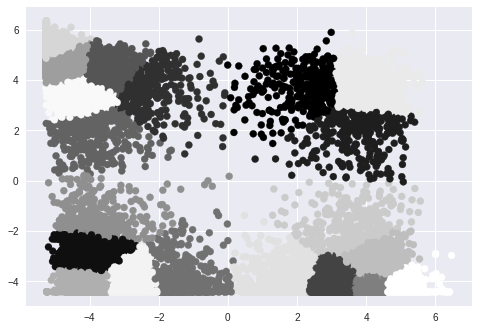

homogeneity score: 0.161
completeness score: 0.175
v-measure: 0.167
adjusted rand score: 0.066
adjusted mutual info score: 0.158


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
all_nmf_matrix = nmf2.fit_transform(all_tfidf_matrix)
kmeans_20 = transform_plot_20('TRUE', 'TRUE', all_nmf_matrix, 'Scaler', all_dataset.target)

In [0]:
from sklearn.metrics.cluster import contingency_matrix
cm = contingency_matrix(all_dataset.target,kmeans_20.labels_)

In [0]:
pd.crosstab(all_dataset.target, kmeans_20.labels_, rownames=['class'], colnames = ['cluster'])

cluster   0    1    2   3   4    5   6   7    8    9   10   11  12  13   14  \
class                                                                         
0          3   65    8  19   2  259   4  17    3  227  19    5   3  17   72   
1        226    3   63  13  45    0   3  44  110    0   6  274  27   4    4   
2        453    0   38  13  21    0  10  26   53    1   1  248  25   0    4   
3        412    2   43   8  28    0   9  36   44    0   0  271  16   1    0   
4        325    0   37  11  28    0  12  67   59    0   1  272  19   1    0   
5        193    1  123   6  38    0   7  26  154    0   4  227  45   1    1   
6        311    0   66   6  42    0   8  19  109    0   2  254  30   2    1   
7         77   26   88  54  47    1  35  93   96   13  20  140  40  24   25   
8         52   53   86  39  45    0  31  75   81   13  30  123  43  37   19   
9         63   23   58  73  54    1  43  88   85    4  25  117  28  25   30   
10        87   17  101  38  55    1  33  77  103    5  13  155  36  15   19   
11        37  105   21  94  16   43  29  52   26  118  23   38  13  32  138   
12       125    9   80  15  50    0  26  86   91    1   9  207  41  13    1   
13        36   96   54  15  29    7  18  40  133   64  47   71  16  57   51   
14        74   37   69  51  39    3  34  78   88   15  22  136  32  18   37   
15         1  103    8   4   4  486   4   2   24  242  13    2   1  24   30   
16         8   92   15  35   3  199  10  14   13  248  15    9   0  16  110   
17         8  112   11   8   4  269  12  20   22  294   9   19  12  21   40   
18         9   95   12  35   4  128   7  19   12  210  22    5   4  34   74   
19         7   71    8  12   5  229   6  16   15  145   7   10   2  10   28   

cluster   15  16  17   18  19  
class                          
0          7  20  11   19  19  
1        116   3  10   21   1  
2         77   1   2    9   3  
3        101   0   8    2   1  
4        116   1   9    5   0  
5        142   1   5   13   1  
6        111   1   4    8   1  
7         84  17  37   58  15  
8        121  23  25   74  26  
9        116  35  37   52  37  
10       107  37  25   44  31  
11        21  62  28   42  53  
12       154   5  13   50   8  
13        66  23   9  132  26  
14       130  27  26   54  17  
15         5   9   3   29   3  
16        18  31  14   27  33  
17        10  10   7   36  16  
18        10  17  17   31  30  
19         9   9   9   23   7

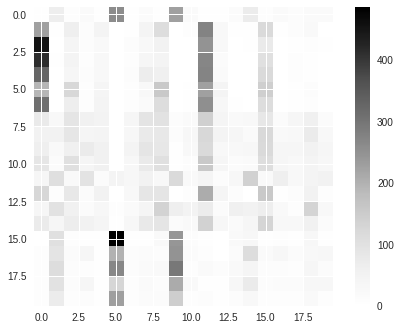

In [0]:
plt.imshow(cm);
plt.colorbar()
plt.show()

**QUESTION 12: Try different dimensions for both truncated SVD and NMF dimensionality reduction techniques and the different transformations of the obtained feature vectors as outlined in above parts.**  
  


Dimensions = 2, 10, 20, 40, 80 were tried for truncated NMF dimensionality reduction and dimensions = 10, 20, 40 were tried for truncated SVD dimensionality reduction. Both the scaling and logarithm transformations were applied to both dimensionality techniques. The best combination for NMF dimensionality reduction among these combinations was when dimensions = 20 and when the logarithm transformation was applied. The best combination among these combinations for SVD dimensionality reduction was when dimensions = 20 and whe the logarithm transformation was applied. The 5 measure scores of the combinations were shown as follows. Logarithm transformation reduced the skewness and typically makes the distribution closer to normal, which contributed to better clustering results. Using NMF vs SVD reduction did not seem to have a significant performance impact. Using only one transformation technique seemed to provide results that were sometimes up to 30% better than using mutiple techniques. The reduced dimensions also had a large impact, with the optimal dimension performing about twice as well as the lowest performing dimensions.


| Dimension | reduction | transformation | homogeneity | completeness | v-measure | adjusted rand | adjusted mutual info |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 20 | NMF | logarithm | 0.356 | 0.405 | 0.379 | 0.195 | 0.354 |
| 20 | SVD | logarithm | 0.364 | 0.397 | 0.380 | 0.194 | 0.362 |


----------------------------------------------------------------------------------------------
DIMENSION: 2
----------------------------------------------------------------------------------------------


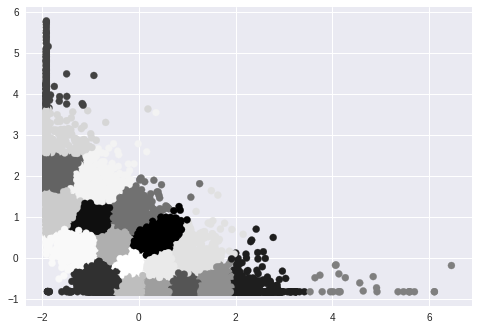

homogeneity score: 0.168
completeness score: 0.180
v-measure: 0.174
adjusted rand score: 0.049
adjusted mutual info score: 0.165


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


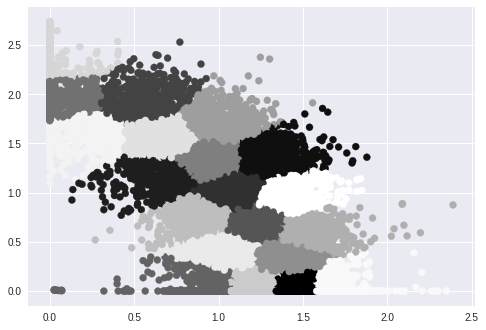

homogeneity score: 0.177
completeness score: 0.183
v-measure: 0.180
adjusted rand score: 0.056
adjusted mutual info score: 0.175


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


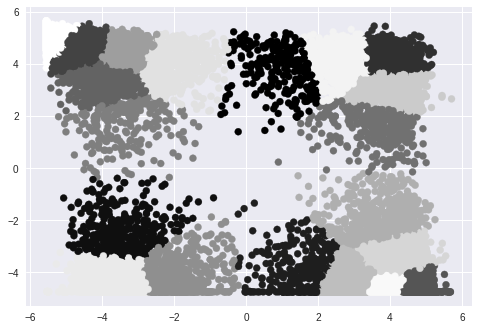

homogeneity score: 0.168
completeness score: 0.183
v-measure: 0.175
adjusted rand score: 0.075
adjusted mutual info score: 0.165


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


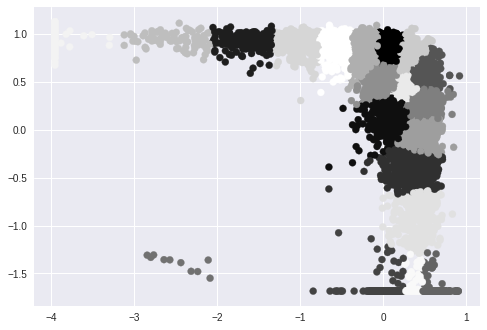

homogeneity score: 0.175
completeness score: 0.190
v-measure: 0.182
adjusted rand score: 0.062
adjusted mutual info score: 0.172


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


----------------------------------------------------------------------------------------------
DIMENSION: 10
----------------------------------------------------------------------------------------------


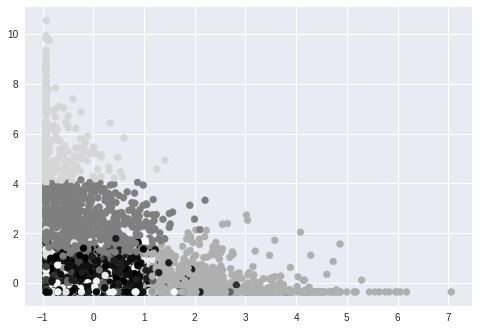

homogeneity score: 0.315
completeness score: 0.353
v-measure: 0.333
adjusted rand score: 0.118
adjusted mutual info score: 0.313


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


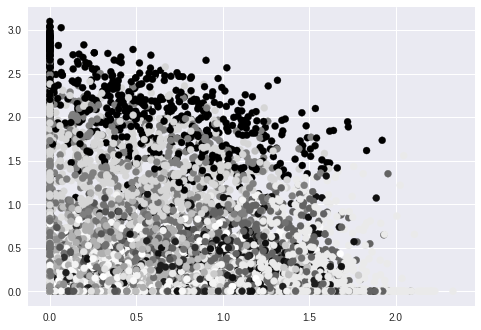

homogeneity score: 0.377
completeness score: 0.393
v-measure: 0.385
adjusted rand score: 0.189
adjusted mutual info score: 0.375


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


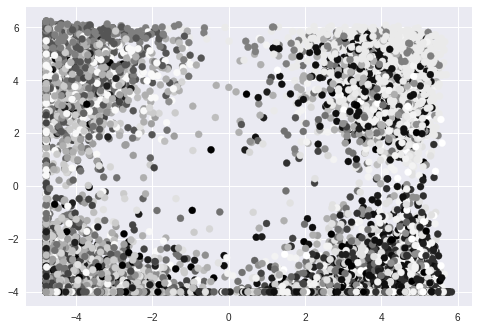

homogeneity score: 0.297
completeness score: 0.298
v-measure: 0.298
adjusted rand score: 0.139
adjusted mutual info score: 0.295


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


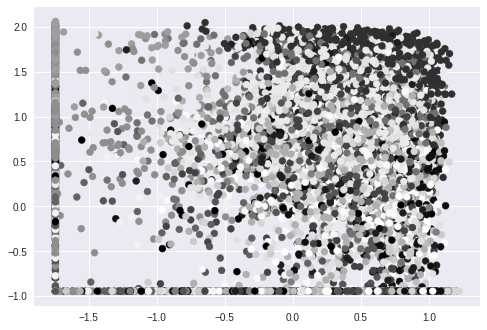

homogeneity score: 0.259
completeness score: 0.261
v-measure: 0.260
adjusted rand score: 0.117
adjusted mutual info score: 0.257


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


----------------------------------------------------------------------------------------------
DIMENSION: 20
----------------------------------------------------------------------------------------------


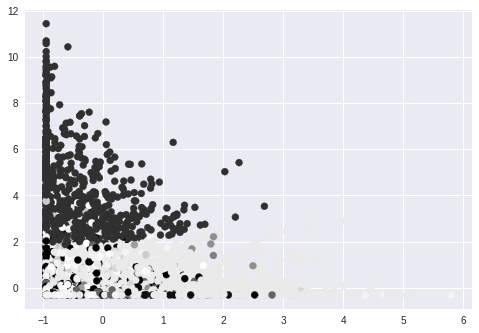

homogeneity score: 0.269
completeness score: 0.361
v-measure: 0.308
adjusted rand score: 0.082
adjusted mutual info score: 0.267


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


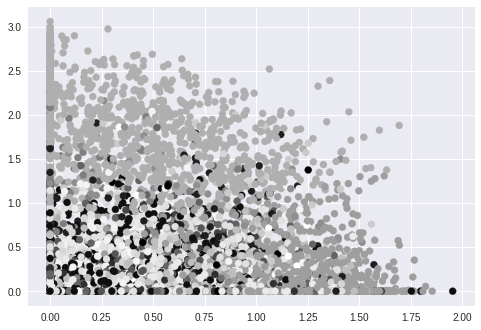

homogeneity score: 0.356
completeness score: 0.405
v-measure: 0.379
adjusted rand score: 0.195
adjusted mutual info score: 0.354


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


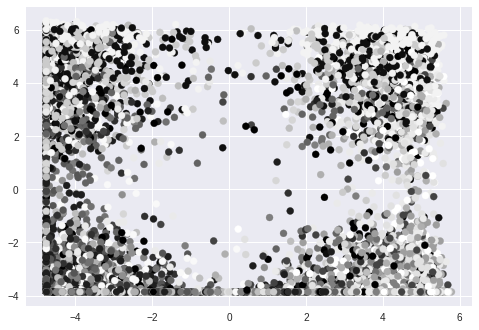

homogeneity score: 0.301
completeness score: 0.303
v-measure: 0.302
adjusted rand score: 0.156
adjusted mutual info score: 0.299


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


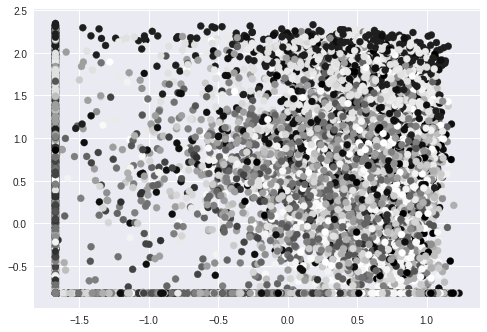

homogeneity score: 0.288
completeness score: 0.289
v-measure: 0.289
adjusted rand score: 0.157
adjusted mutual info score: 0.286


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


----------------------------------------------------------------------------------------------
DIMENSION: 40
----------------------------------------------------------------------------------------------


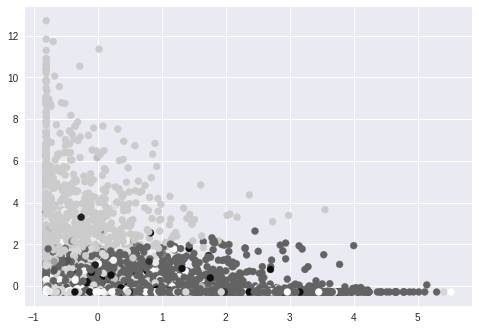

homogeneity score: 0.224
completeness score: 0.335
v-measure: 0.269
adjusted rand score: 0.062
adjusted mutual info score: 0.221


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


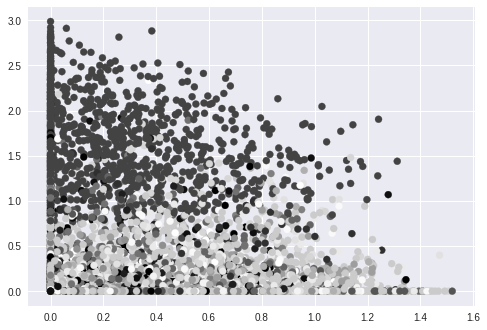

homogeneity score: 0.366
completeness score: 0.389
v-measure: 0.377
adjusted rand score: 0.205
adjusted mutual info score: 0.364


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


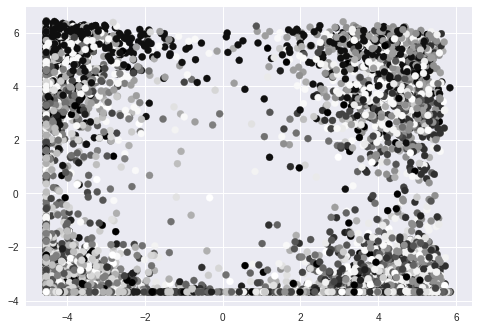

homogeneity score: 0.338
completeness score: 0.339
v-measure: 0.339
adjusted rand score: 0.193
adjusted mutual info score: 0.336


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


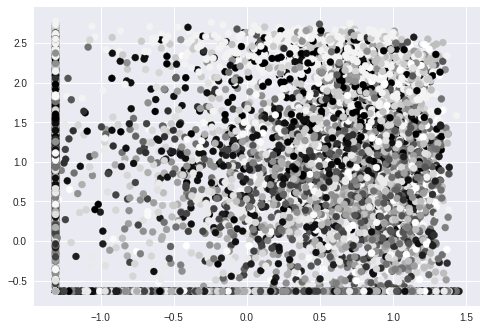

homogeneity score: 0.274
completeness score: 0.276
v-measure: 0.275
adjusted rand score: 0.151
adjusted mutual info score: 0.272


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


----------------------------------------------------------------------------------------------
DIMENSION: 80
----------------------------------------------------------------------------------------------


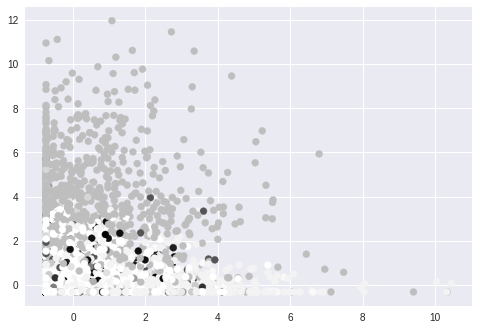

homogeneity score: 0.240
completeness score: 0.386
v-measure: 0.296
adjusted rand score: 0.078
adjusted mutual info score: 0.237


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


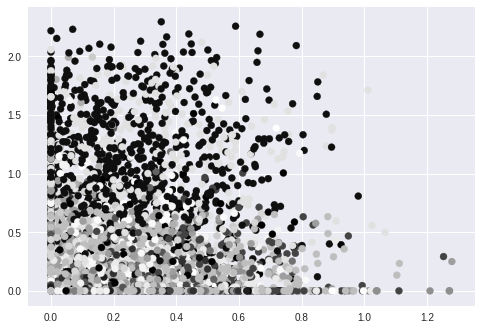

homogeneity score: 0.307
completeness score: 0.344
v-measure: 0.325
adjusted rand score: 0.146
adjusted mutual info score: 0.305


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


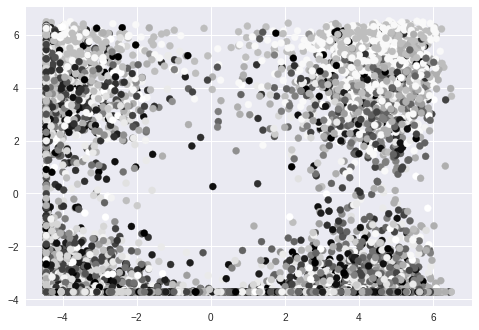

homogeneity score: 0.313
completeness score: 0.317
v-measure: 0.315
adjusted rand score: 0.181
adjusted mutual info score: 0.311


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


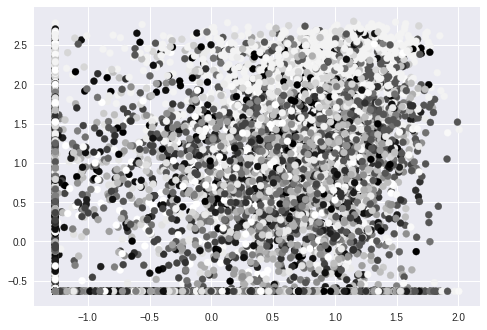

homogeneity score: 0.350
completeness score: 0.357
v-measure: 0.353
adjusted rand score: 0.220
adjusted mutual info score: 0.348


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
dimensions= [2,10,20,40,80]
d_kmeans = []
for d in dimensions:
  nmf_d = NMF(n_components=d)
  d_nmf_matrix = nmf_d.fit_transform(all_tfidf_matrix)
  kmn = []
  print("----------------------------------------------------------------------------------------------")
  print("DIMENSION: {}".format(d))
  print("----------------------------------------------------------------------------------------------")
  kmn.append(transform_plot_20('TRUE', 'FALSE', d_nmf_matrix, 'Scaler', all_dataset.target))
  kmn.append(transform_plot_20('FALSE', 'TRUE', d_nmf_matrix, 'Log', all_dataset.target))
  kmn.append(transform_plot_20('TRUE', 'TRUE', d_nmf_matrix, 'Scaler', all_dataset.target))
  kmn.append(transform_plot_20('TRUE', 'TRUE', d_nmf_matrix, 'Log', all_dataset.target))
  d_kmeans.append(kmn)
  
  

----------------------------------------------------------------------------------------------
DIMENSION: 10
----------------------------------------------------------------------------------------------


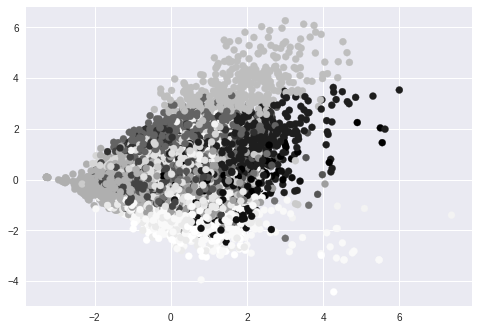

homogeneity score: 0.307
completeness score: 0.353
v-measure: 0.328
adjusted rand score: 0.123
adjusted mutual info score: 0.305


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


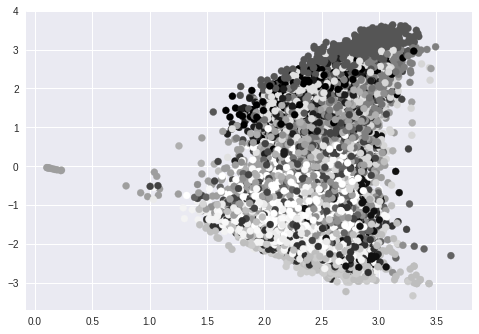

homogeneity score: 0.399
completeness score: 0.407
v-measure: 0.403
adjusted rand score: 0.230
adjusted mutual info score: 0.397


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


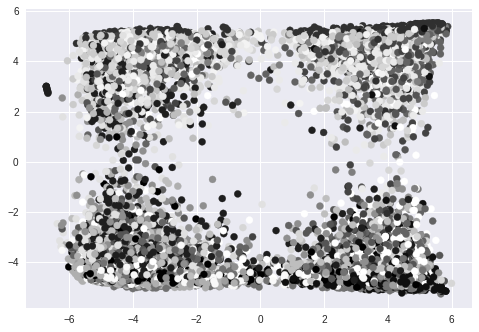

homogeneity score: 0.371
completeness score: 0.372
v-measure: 0.371
adjusted rand score: 0.213
adjusted mutual info score: 0.369


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


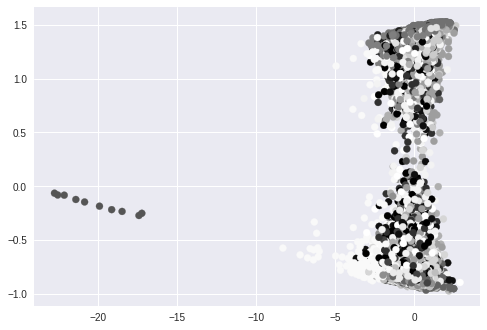

homogeneity score: 0.361
completeness score: 0.372
v-measure: 0.367
adjusted rand score: 0.225
adjusted mutual info score: 0.359


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


----------------------------------------------------------------------------------------------
DIMENSION: 20
----------------------------------------------------------------------------------------------


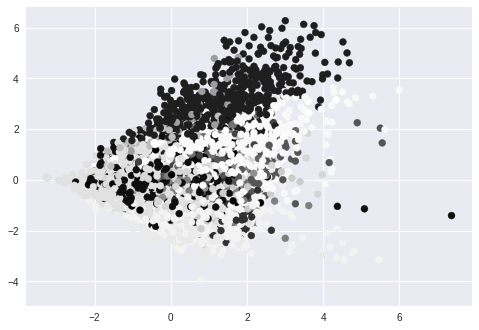

homogeneity score: 0.273
completeness score: 0.366
v-measure: 0.313
adjusted rand score: 0.083
adjusted mutual info score: 0.271


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


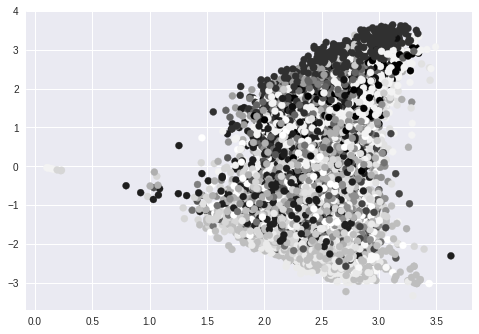

homogeneity score: 0.364
completeness score: 0.397
v-measure: 0.380
adjusted rand score: 0.194
adjusted mutual info score: 0.362


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


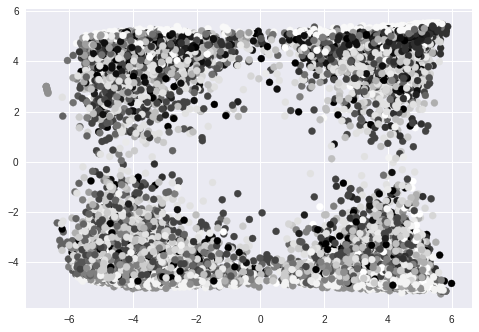

homogeneity score: 0.329
completeness score: 0.338
v-measure: 0.333
adjusted rand score: 0.195
adjusted mutual info score: 0.326


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


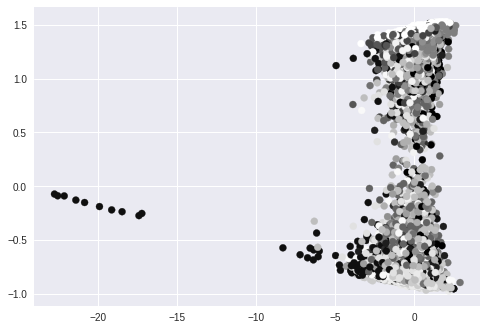

homogeneity score: 0.327
completeness score: 0.337
v-measure: 0.332
adjusted rand score: 0.191
adjusted mutual info score: 0.325


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


----------------------------------------------------------------------------------------------
DIMENSION: 40
----------------------------------------------------------------------------------------------


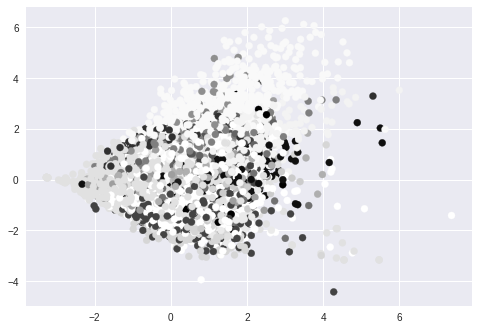

homogeneity score: 0.240
completeness score: 0.335
v-measure: 0.280
adjusted rand score: 0.066
adjusted mutual info score: 0.237


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


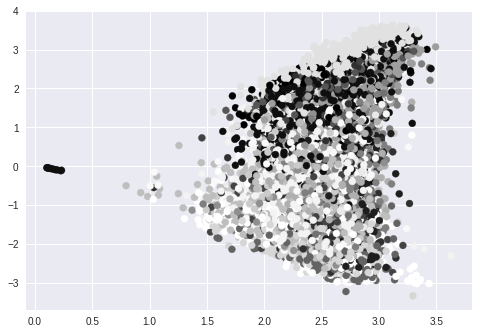

homogeneity score: 0.344
completeness score: 0.366
v-measure: 0.355
adjusted rand score: 0.174
adjusted mutual info score: 0.342


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


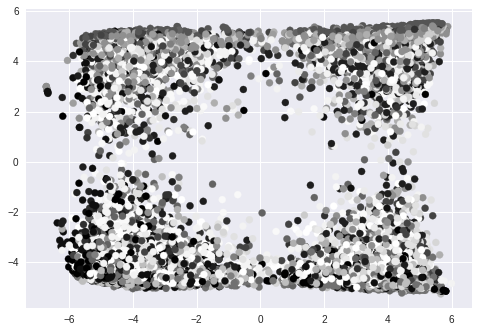

homogeneity score: 0.321
completeness score: 0.328
v-measure: 0.325
adjusted rand score: 0.178
adjusted mutual info score: 0.319


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


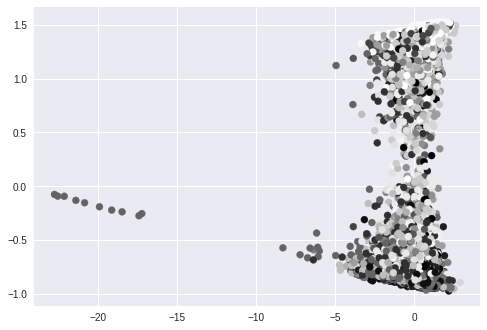

homogeneity score: 0.315
completeness score: 0.322
v-measure: 0.319
adjusted rand score: 0.172
adjusted mutual info score: 0.313


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [0]:
dimensions= [10,20,40]
d_svd_kmeans = []
for d in dimensions:
  svd_d = TruncatedSVD(n_components=d)
  d_nmf_matrix = svd_d.fit_transform(all_tfidf_matrix)
  kmn = []
  print("----------------------------------------------------------------------------------------------")
  print("DIMENSION: {}".format(d))
  print("----------------------------------------------------------------------------------------------")
  kmn.append(transform_plot_20('TRUE', 'FALSE', d_nmf_matrix, 'Scaler', all_dataset.target))
  kmn.append(transform_plot_20('FALSE', 'TRUE', d_nmf_matrix, 'Log', all_dataset.target))
  kmn.append(transform_plot_20('TRUE', 'TRUE', d_nmf_matrix, 'Scaler', all_dataset.target))
  kmn.append(transform_plot_20('TRUE', 'TRUE', d_nmf_matrix, 'Log', all_dataset.target))
  d_svd_kmeans.append(kmn)

In [0]:
best_nmf = d_kmeans[2][1] #d=20, transform_plot_20('FALSE', 'TRUE', d_nmf_matrix, 'Log', all_dataset.target)
best_svd = d_svd_kmeans[1][1] #d=20, transform_plot_20('FALSE', 'TRUE', d_nmf_matrix, 'Log', all_dataset.target)

In [0]:
nmf_cm = contingency_matrix(all_dataset.target,best_nmf.labels_)
svd_cm = contingency_matrix(all_dataset.target,best_svd.labels_)

homogeneity score: 0.356
completeness score: 0.405
v-measure: 0.379
adjusted rand score: 0.195
adjusted mutual info score: 0.354
contingency matrix:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


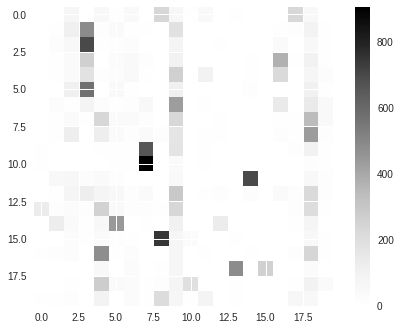

In [0]:
#homogeneity score
print('homogeneity score: %0.3f' % homogeneity_score(all_dataset.target, best_nmf.labels_))

#completeness score
print('completeness score: %0.3f' % completeness_score(all_dataset.target, best_nmf.labels_))

#v-measure
print('v-measure: %0.3f' % v_measure_score(all_dataset.target, best_nmf.labels_))

#adjusted rand score
print('adjusted rand score: %0.3f' % adjusted_rand_score(all_dataset.target, best_nmf.labels_))

#adjusted mutual info score
print('adjusted mutual info score: %0.3f' % adjusted_mutual_info_score(all_dataset.target, best_nmf.labels_))
print('contingency matrix:')
plt.imshow(nmf_cm)
plt.colorbar()
plt.show()

homogeneity score: 0.364
completeness score: 0.397
v-measure: 0.380
adjusted rand score: 0.194
adjusted mutual info score: 0.362
contingency matrix:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


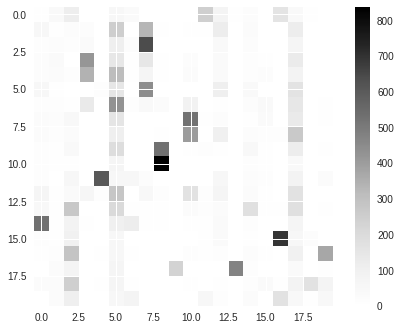

In [0]:
#homogeneity score
print('homogeneity score: %0.3f' % homogeneity_score(all_dataset.target, best_svd.labels_))

#completeness score
print('completeness score: %0.3f' % completeness_score(all_dataset.target, best_svd.labels_))

#v-measure
print('v-measure: %0.3f' % v_measure_score(all_dataset.target, best_svd.labels_))

#adjusted rand score
print('adjusted rand score: %0.3f' % adjusted_rand_score(all_dataset.target, best_svd.labels_))

#adjusted mutual info score
print('adjusted mutual info score: %0.3f' % adjusted_mutual_info_score(all_dataset.target, best_svd.labels_))

print('contingency matrix:')
plt.imshow(svd_cm);
plt.colorbar()
plt.show()